In [8]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [9]:
np.random.seed(42)

In [10]:
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
from dotenv import load_dotenv
load_dotenv()


alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

## Data Collection

In [12]:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [13]:
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


# Monte Carlo Situation

In [14]:
daily_returns = df.pct_change().dropna()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130


In [15]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']

print(avg_daily_return_spy*100)
print(avg_daily_return_agg*100)

0.10401250682146959
0.021277231473764174


In [16]:
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']

In [17]:
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

print(spy_last_price)
print(agg_last_price)

321.92
112.37


In [18]:
### GIVEN DATA
## Set up the Monte Carlo Parameters

number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [19]:
### Run Monte Carlo

In [20]:
for x in range(number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    for i in range(number_records):

        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))

        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)

    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)

    simulated_daily_returns = monte_carlo.pct_change()


    weights = [0.6, 0.4]


    portfolio_daily_returns = simulated_daily_returns.dot(weights)


    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()


portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002924,0.995999,0.993589,0.999839,1.005673,1.006943,1.009401,0.996558,1.001958,0.999350,...,1.002269,0.995970,1.007308,1.000163,0.997898,1.003207,0.996441,0.994146,1.003209,0.997553
2,1.007960,0.999998,0.993068,0.999039,1.009071,0.998193,1.004123,0.986299,1.001346,1.007829,...,1.004518,1.003370,1.010545,1.001969,0.999475,1.000274,0.996136,0.994776,1.003311,1.001444
3,1.007370,1.000231,0.996724,0.993520,1.008617,1.001408,1.008137,0.980584,1.001321,1.016101,...,1.004743,1.006240,1.015344,1.003629,0.993173,0.999241,1.000000,1.000495,1.006827,1.000482
4,1.016195,1.003283,0.993397,0.999441,1.010295,0.996675,1.007118,0.978044,1.009298,1.006308,...,1.006802,1.004677,1.014131,1.008910,0.999443,0.996475,0.994644,1.001387,1.011503,1.004131


In [21]:
### Visualize the Simulations

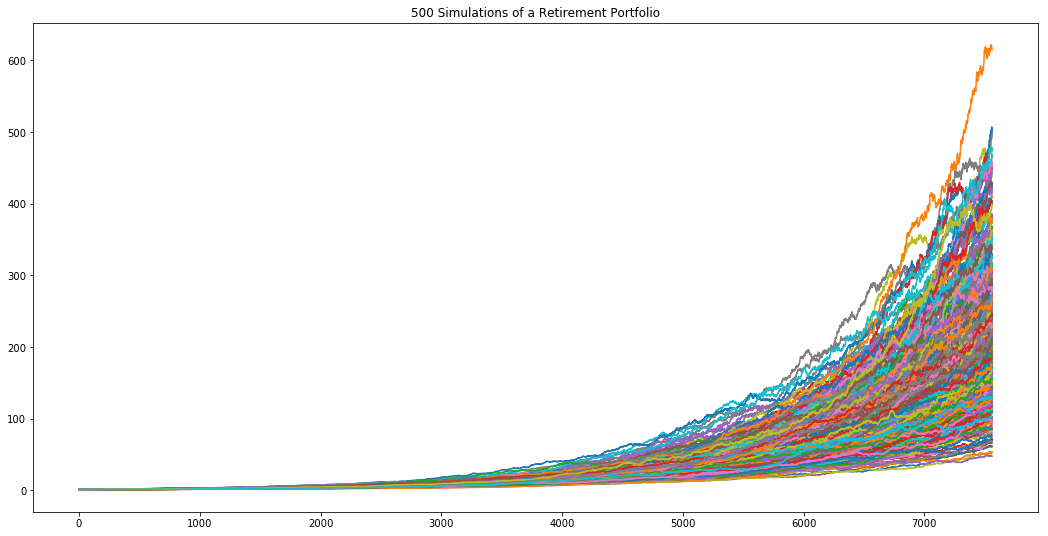

In [22]:
plot_title = f"{x+1} Simulations of a Retirement Portfolio"
portfolio_cumulative_returns.plot(legend = None, title = plot_title, figsize = (18,9))

In [26]:
# Select the last row for the cumulative returns (cumulative returns at 30 years) 30 or 20???

portfolio_cumulative_returns_30years = portfolio_cumulative_returns.iloc[-1, :] 
portfolio_cumulative_returns_30years.head()



0    224.965889
1    185.695782
2    254.090683
3    267.175574
4    242.897877
Name: 7560, dtype: float64

In [27]:
# Display the 90% confidence interval for the ending returns #?????????
confidence_interval_30_years = portfolio_cumulative_returns_30years.quantile(q=[.05, .5, .95])


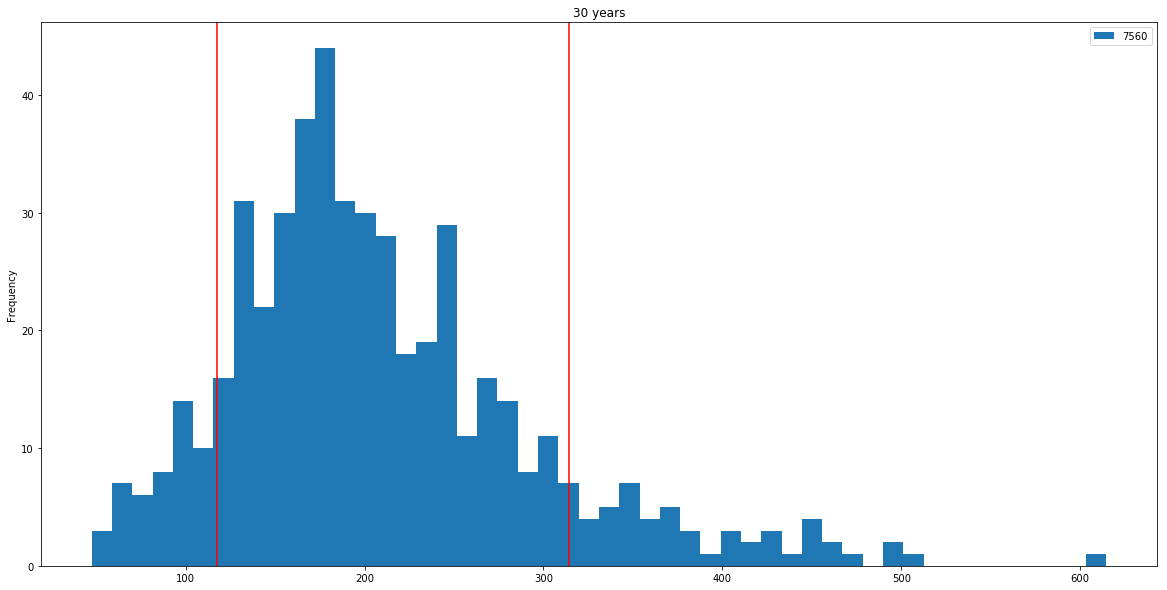

In [50]:
# Visualize the distribution of the ending returns
plt.figure();
portfolio_cumulative_returns_30years.plot(kind = 'hist', bins = 50, title = "30 years", legend = True, figsize = (20,10))
plt.axvline(confidence_interval_30_years.iloc[0], color = 'r')
plt.axvline(confidence_interval_30_years.iloc[2], color = 'r')


# Retirment Analysis

##  What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [29]:
initial_investment = 20000
confidence_interval_30_years = portfolio_cumulative_returns_30years.quantile(q=[.1, .5, .9])
tenth = int(confidence_interval_30_years.iloc[0] * initial_investment)
fifty = int(confidence_interval_30_years.iloc[1] * initial_investment)
nintey = int(confidence_interval_30_years.iloc[2] * initial_investment)

In [30]:
print(f"The cumulative returns at 30 years for the 10th, 50th, and 90th percentiles are ${tenth}, ${fifty}, and ${nintey}, respectively.")

The cumulative returns at 30 years for the 10th, 50th, and 90th percentiles are $2347518, $3796876, and $6286947, respectively.


## Given an initial investment of $20,000, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [31]:
initial_investment = 20000


investment_pnl_lower_bound = initial_investment * confidence_interval_30_years.iloc[0]
investment_pnl_middle_bound = initial_investment * confidence_interval_30_years.iloc[1]
investment_pnl_upper_bound = initial_investment * confidence_interval_30_years.iloc[2]
investment_pnl_lower_bound = int(investment_pnl_lower_bound)
investment_pnl_upper_bound = int(investment_pnl_upper_bound) 
investment_pnl_middle_bound = int(investment_pnl_middle_bound)

In [32]:
print(f"The expected portfolio return for initial investment of $20,000"
      f" over the next 30 Years will end within in the range of 10th percential:"
      f" ${investment_pnl_lower_bound}, 50th percential: ${investment_pnl_middle_bound}"
      f"  and 90th percential: ${investment_pnl_upper_bound}")

The expected portfolio return for initial investment of $20,000 over the next 30 Years will end within in the range of 10th percential: $2347518, 50th percential: $3796876  and 90th percential: $6286947


## Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

In [49]:
projected_yearly_income_before_tax = 100000 # I screwed this up I know
if (investment_pnl_upper_bound * .04) > projected_yearly_income_before_tax:
    print(f"Yes, the 4% withdrawl from the 10th percentile is {investment_pnl_upper_bound * .04} and is above is the projected annual income of {projected_yearly_income_before_tax}")
else:
    print(f"No, the 4% withdrawl from the 10th percentile is {investment_pnl_upper_bound * .04} and is at or below the projected annual income of {projected_yearly_income_before_tax}")

Yes, the 4% withdrawl from the 10th percentile is 251477.88 and is above is the projected annual income of 100000


## How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [45]:
initial_investment_30k = 30000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound_30k = initial_investment_30k * confidence_interval_30_years.iloc[0]
investment_pnl_middle_bound_30k = initial_investment_30k * confidence_interval_30_years.iloc[1]
investment_pnl_upper_bound_30k = initial_investment_30k * confidence_interval_30_years.iloc[2]
investment_pnl_lower_bound_30k = int(investment_pnl_lower_bound_30k)
investment_pnl_upper_bound_30k = int(investment_pnl_middle_bound_30k) 
investment_pnl_middle_bound_0k = int(investment_pnl_upper_bound_30k)
# Print the results
print(f"The expected portfolio return for initial investment of ${initial_investment_30k}"
      f" over the next 30 Years will end within in the range of 10th percential:"
      f" ${investment_pnl_lower_bound_30k}, 50th percential: ${investment_pnl_middle_bound_30k}"
      f"  and 90th percential: ${investment_pnl_upper_bound_30k}")

The expected portfolio return for initial investment of $30000 over the next 30 Years will end within in the range of 10th percential: $3521278, 50th percential: $5695314.976183014  and 90th percential: $5695314
